In [1]:
import math
import os

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import us as us_states

plt.style.use('bmh')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
def good_states(x):
    non_states = ['Evacuee', 'Islands', 'Recovered', 'Princess', 'Guam', 'Samoa']
    return x is not None and x.split(' ')[-1] not in non_states


def lookup_state(x):
    s = us_states.states.lookup(x.split(',')[-1].strip())
    if s is not None:
        return s.name
    return None


def parse_daily_reports(path):
    states = None
    for f in sorted(os.listdir(path)):
        if f[-3:] == 'csv':
            df = pd.read_csv(path + f)
            df['Date'] = pd.to_datetime(f[0:-4])
            try:
                us = df[df.Country_Region == 'US']
            except:
                us = df[df['Country/Region'] == 'US']
                us['Province_State'] = us['Province/State'].apply(lookup_state)

            idx = us['Province_State'].apply(good_states)
            us = us[idx]

            if states is None:
                states = us
            else:
                states = pd.concat([states, us])
    return states


all_states_df = parse_daily_reports('./csse_covid_19_data/csse_covid_19_daily_reports/')

def daily_new_cases(state):
    if state:
        df = all_states_df[all_states_df.Province_State == state]
    else:
        df = all_states_df
    df = df[df.Date > '2020-03-01']
    diff = df.groupby(by='Date').Confirmed.sum().diff().apply(lambda x: max(x, 0))
    tail = diff.rolling(10).mean().tail(20)
    slope = stats.linregress(range(len(tail)), tail).slope
    return slope, diff, state


def plot_state(diff, ax):
    diff.rolling(10).mean().plot(ax=ax, color='red')
    ax.bar(diff.index, diff.values)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gcf().autofmt_xdate();

/Users/michael/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


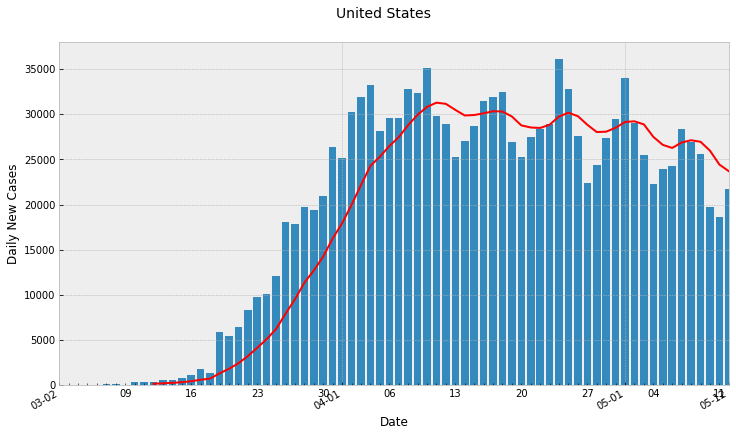

In [4]:
fig, ax = plt.subplots(figsize=(12, 7))

t = daily_new_cases(None)
plot_state(t[1], ax)
ax.set_ylabel('Daily New Cases');
fig.suptitle('United States', y=.95, fontsize='14');

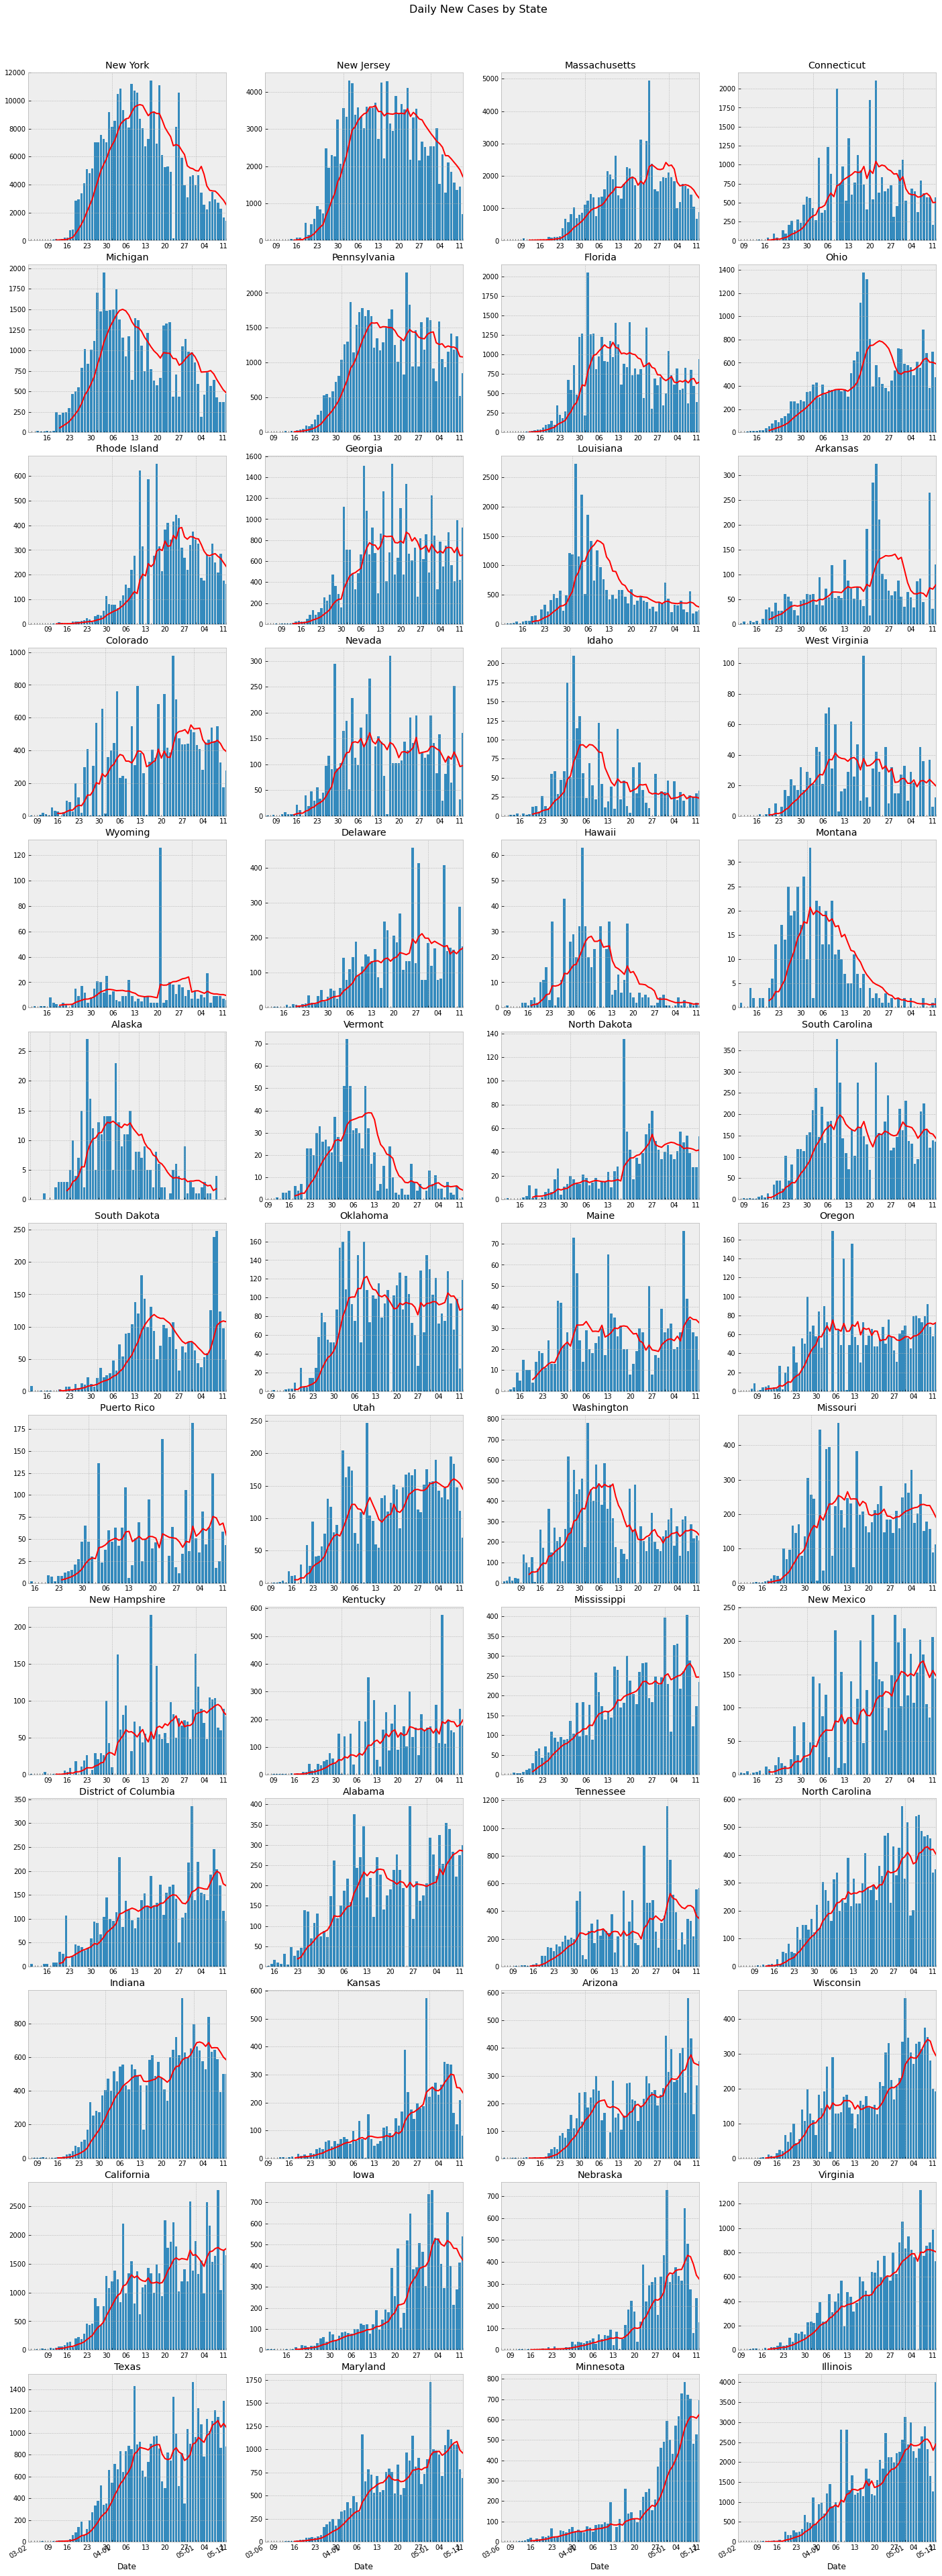

In [6]:
rows = 13
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(20, 70))
fig.tight_layout(pad=3.0)

state_daily_cases = sorted(
    [daily_new_cases(x) 
     for x in all_states_df.Province_State.unique()], 
    key=lambda x: x[0]
)

for i, state in enumerate(state_daily_cases):
    ax = axes[math.floor(i / cols), i % cols]
    plot_state(state[1], ax)
    ax.set_title(state[2])
    
st = fig.suptitle('Daily New Cases by State', y=.95, fontsize='16');
fig.subplots_adjust(top=0.93)